In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
# Reshape the data to have a single channel
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

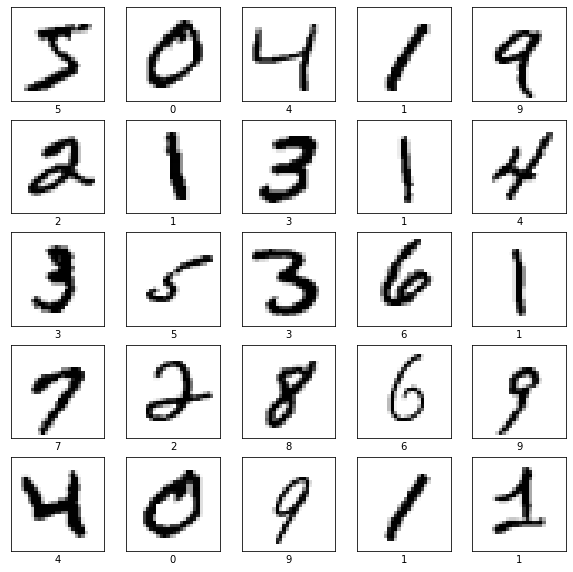

In [4]:
# Plot a few examples from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

# Simple Three Layer MLP

In [5]:
# Define the MLP model
model = Sequential([
    Flatten(input_shape=(28, 28)),  # Flatten the 28x28 images to a 1D array
    Dense(128, activation='relu'),  # 128 neurons, ReLU activation
    Dense(64, activation='relu'),   # 64 neurons, ReLU activation
    Dense(10, activation='softmax') # Output layer with 10 neurons for 10 classes, softmax activation
])

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 11s 6ms/step - loss: 0.2662 - accuracy: 0.9220 - val_loss: 0.1298 - val_accuracy: 0.9612
Epoch 2/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1090 - accuracy: 0.9674 - val_loss: 0.1090 - val_accuracy: 0.9685
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0786 - accuracy: 0.9763 - val_loss: 0.1140 - val_accuracy: 0.9647
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0578 - accuracy: 0.9820 - val_loss: 0.0999 - val_accuracy: 0.9715
Epoch 5/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0444 - accuracy: 0.9862 - val_loss: 0.0887 - val_accuracy: 0.9736
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.1024 - val_accuracy: 0.9736
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0296 - accuracy: 0.9903 - val_loss: 0.1020 - val_accurac

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy of Simple Three Layer MLP:", (test_accuracy*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0942 - accuracy: 0.9763
Test Accuracy of Simple Three Layer MLP: 97.63000011444092


In [9]:
# Get predictions for test data
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


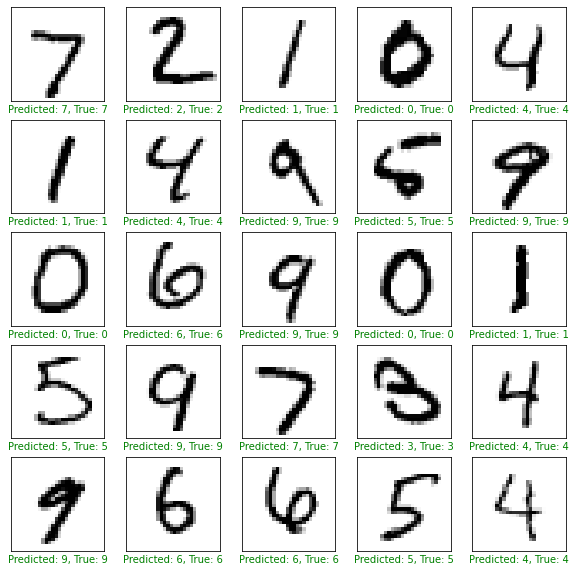

In [10]:
# Plot some images along with their predicted labels
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    predicted_label = predictions[i].argmax()
    true_label = y_test[i]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'Predicted: {predicted_label}, True: {true_label}', color=color)
plt.show()

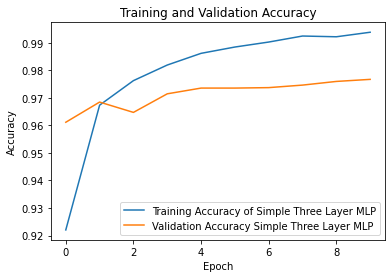

In [11]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy of Simple Three Layer MLP')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy Simple Three Layer MLP')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# gMLP model

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Define gMLP model
def gMLP(image_shape=(28, 28, 1), num_classes=10, hidden_units=256, num_blocks=6, mlp_ratio=4, dropout_rate=0.1):
    inputs = layers.Input(shape=image_shape)
    x = layers.Reshape((-1, image_shape[0] * image_shape[1]))(inputs)
    
    # Patch embedding
    num_patches = x.shape[1]
    patch_dim = hidden_units // mlp_ratio
    embeddings = layers.Dense(hidden_units)(x)
    
    # Positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positions = tf.expand_dims(positions, 0)
    positions = tf.one_hot(positions, num_patches)
    positional_embeddings = layers.Dense(hidden_units)(positions)
    
    x = embeddings + positional_embeddings
    
    # gMLP blocks
    for _ in range(num_blocks):
        # Spatial gating unit
        y = layers.Dense(hidden_units, activation='relu')(x)
        y = layers.Dense(hidden_units, activation='sigmoid')(y)
        x = x * y
        
        # Layer normalization
        x = layers.LayerNormalization()(x)
        
        # Feed-forward network
        x = layers.Dense(hidden_units)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(hidden_units)(x)
        x = layers.Dropout(dropout_rate)(x)
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Classification head
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model



In [33]:
# Create and compile the gMLP model
model = gMLP()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [34]:
# Train the model
history =model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 67s 37ms/step - loss: 0.4554 - accuracy: 0.8819 - val_loss: 0.2460 - val_accuracy: 0.9442
Epoch 2/10
1500/1500 [==============================] - 52s 35ms/step - loss: 0.2560 - accuracy: 0.9390 - val_loss: 0.2467 - val_accuracy: 0.9353
Epoch 3/10
1500/1500 [==============================] - 52s 35ms/step - loss: 0.2188 - accuracy: 0.9483 - val_loss: 0.2488 - val_accuracy: 0.9386
Epoch 4/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.2046 - accuracy: 0.9503 - val_loss: 0.1961 - val_accuracy: 0.9533
Epoch 5/10
1500/1500 [==============================] - 53s 35ms/step - loss: 0.2185 - accuracy: 0.9452 - val_loss: 0.2284 - val_accuracy: 0.9413
Epoch 6/10
1500/1500 [==============================] - 53s 35ms/step - loss: 0.2265 - accuracy: 0.9415 - val_loss: 0.1841 - val_accuracy: 0.9550
Epoch 7/10
1500/1500 [==============================] - 51s 34ms/step - loss: 0.2053 - accuracy: 0.9452 - val_loss: 0.4545 -

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy of gMLP model:", (test_accuracy*100))

313/313 [==============================] - 7s 14ms/step - loss: 0.2031 - accuracy: 0.9416
Test Accuracy of gMLP model: 94.16000247001648


In [36]:
# Get predictions for test data
predictions = model.predict(x_test)

313/313 [==============================] - 7s 15ms/step


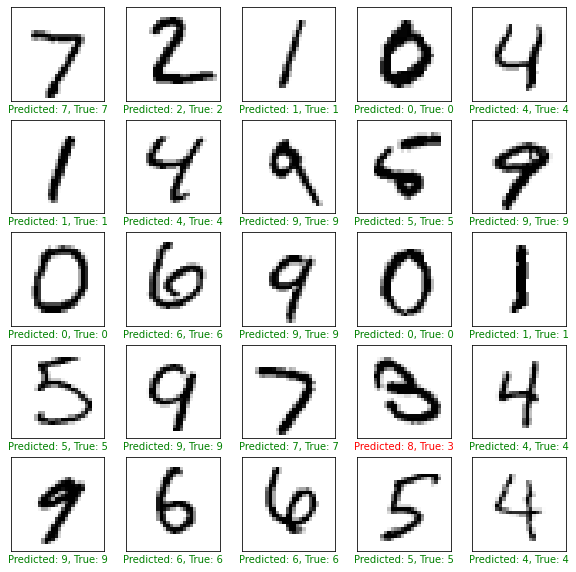

In [37]:
# Plot some images along with their predicted labels
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]), cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    true_label = y_test[i]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'Predicted: {predicted_label}, True: {true_label}', color=color)
plt.show()

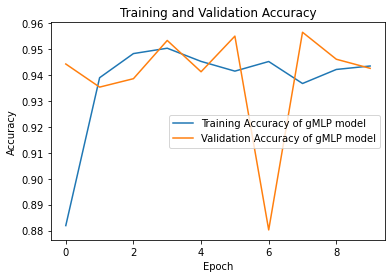

In [38]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy of gMLP model')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy of gMLP model')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ResMLP

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# Define ResMLP model
def ResMLP(image_shape=(28, 28, 1), num_classes=10, hidden_units=256, num_layers=6, mlp_ratio=4, dropout_rate=0.1):
    inputs = layers.Input(shape=image_shape)
    x = layers.Reshape((-1, image_shape[0] * image_shape[1]))(inputs)
    
    # Patch embedding
    num_patches = x.shape[1]
    patch_dim = hidden_units // mlp_ratio
    embeddings = layers.Dense(hidden_units)(x)
    
    # Positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positions = tf.expand_dims(positions, 0)
    positions = tf.one_hot(positions, num_patches)
    positional_embeddings = layers.Dense(hidden_units)(positions)
    
    x = embeddings + positional_embeddings
    
    # Residual MLP blocks
    for _ in range(num_layers):
        # First layer
        y = layers.LayerNormalization()(x)
        y = layers.Dense(hidden_units, activation='gelu')(y)
        y = layers.Dropout(dropout_rate)(y)
        
        # Second layer
        y = layers.LayerNormalization()(y)
        y = layers.Dense(hidden_units)(y)
        y = layers.Dropout(dropout_rate)(y)
        
        # Residual connection
        x = x + y
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Classification head
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model



In [41]:
# Create and compile the ResMLP model
model = ResMLP()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
# Train the model
history =model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1500/1500 [==============================] - 64s 35ms/step - loss: 0.4985 - accuracy: 0.8893 - val_loss: 0.2226 - val_accuracy: 0.9407
Epoch 2/10
1500/1500 [==============================] - 52s 34ms/step - loss: 0.1849 - accuracy: 0.9466 - val_loss: 0.1389 - val_accuracy: 0.9588
Epoch 3/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.1363 - accuracy: 0.9599 - val_loss: 0.1769 - val_accuracy: 0.9477
Epoch 4/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.1092 - accuracy: 0.9663 - val_loss: 0.1533 - val_accuracy: 0.9585
Epoch 5/10
1500/1500 [==============================] - 57s 38ms/step - loss: 0.1001 - accuracy: 0.9695 - val_loss: 0.1616 - val_accuracy: 0.9544
Epoch 6/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.0940 - accuracy: 0.9700 - val_loss: 0.1412 - val_accuracy: 0.9595
Epoch 7/10
1500/1500 [==============================] - 34s 23ms/step - loss: 0.0827 - accuracy: 0.9740 - val_loss: 0.0924 -

In [43]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy of ResMLP:", (test_accuracy*100))

313/313 [==============================] - 4s 8ms/step - loss: 0.0870 - accuracy: 0.9772
Test Accuracy of ResMLP: 97.71999716758728


In [44]:
# Get predictions for test data
predictions = model.predict(x_test)

313/313 [==============================] - 3s 7ms/step


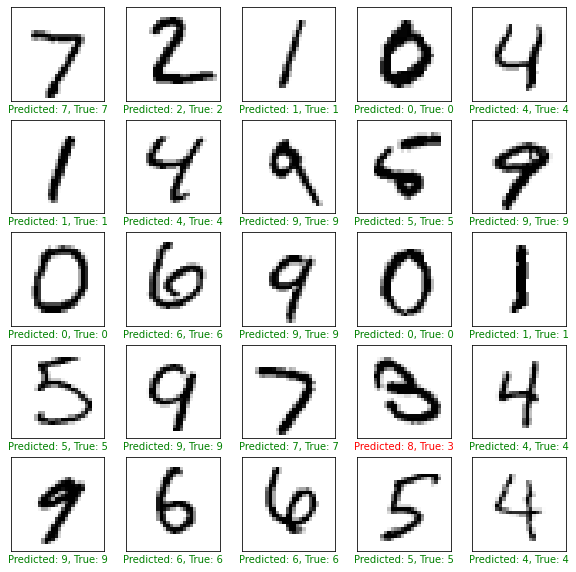

In [45]:
# Plot some images along with their predicted labels
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]), cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    true_label = y_test[i]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'Predicted: {predicted_label}, True: {true_label}', color=color)
plt.show()

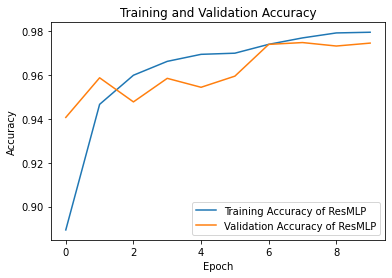

In [46]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy of ResMLP')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy of ResMLP')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()